In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import os
import random
import math

from torch.utils.data.dataset import Dataset

INPUT_PATH = "/var/www/nextcloud/data/dbc2017/files/nodule_npy/"
OUTPUT_PATH = "/var/www/nextcloud/data/dbc2017/files/"

In [2]:
randnum = random.randint(0,100)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
nz = 100
n_epochs = 50
ngf = 64
ngpu = 1
LEVELS_NUM = 2

cuda = True if torch.cuda.is_available() else False
print(device)

cuda:0


In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def chunks(arr, m):
    nchunk = int(math.ceil(len(arr) / float(m)))
    return [arr[i:i + nchunk] for i in range(0, len(arr), nchunk)]

def ten_folder(arr, number):
    training_set = []
    test_set = []
    for j in range(len(arr)):
        if number == j:
            test_set.extend(arr[j])
        else:
            training_set.extend(arr[j])
    return training_set, test_set


class MyDataset(Dataset):
    def __init__(self, images,labels):
        self.images = images
        self.labels = labels

    def __getitem__(self, index):#返回的是tensor
        img = self.images[index]
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.images)

In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        self.label_emb = nn.Embedding(LEVELS_NUM, 100)

        self.project = nn.Sequential(
          nn.Linear(nz, 1 * 5 * 5 * ngf * 4, bias=False)
        )
        self.deconv = nn.Sequential(
          # input is Z, going into a deconvolution
          # state size. BATCH_SIZE x (ngf*4) x 1 x 5 x 5
          nn.ConvTranspose3d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm3d(ngf * 2),
          nn.ReLU(True),
          # state size. BATCH_SIZE x (ngf*2) x 2 x 10 x 10
          nn.ConvTranspose3d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm3d(ngf),
          nn.ReLU(True),
          # state size. BATCH_SIZE x (ngf) x 4 x 20 x 20
          nn.ConvTranspose3d(ngf, 1, kernel_size=4, stride=2, padding=1, bias=False),
          nn.Tanh()
          # state size. BATCH_SIZE x 1 x 8 x 40 x 40
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        
        x = self.project(gen_input)
        # Conv3d的规定输入数据格式为(batch, channel, Depth, Height, Width)
        x = x.view(-1, ngf * 4, 1, 5, 5)
        
        if noise.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.deconv, x, range(self.ngpu))
        else:
            output = self.deconv(x)

        return output


# Discriminator
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)

class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=(2,9,9)):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv3d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=kernel_size,
                                stride=1
                              )

    def forward(self, x):
        return F.relu(self.conv(x))


class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=(2,9,9), num_routes=32 * 12 * 12 * 6):
        super(PrimaryCaps, self).__init__()

        self.capsules = nn.ModuleList([
          nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=(1,2,2), padding=0) 
                      for _ in range(num_capsules)])
  
    def forward(self, x):
        u = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
        u = torch.cat(u, dim=-1)
        return self.squash(u)
  
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor



class DigitCaps(nn.Module):
    def __init__(self, num_capsules=1, num_routes=32 * 12 * 12 * 6, in_channels=8, out_channels=16, num_iterations=3):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules
        self.num_iterations = num_iterations
        self.route_weights = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels)).to(device)

    def forward(self, x):
        # 矩阵相乘
        # x.size(): [1, batch_size, in_capsules, 1, dim_in_capsule]
        # weight.size(): [num_capsules, 1, num_route, in_channels, out_channels]
        priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]
        logits = Variable(torch.zeros(*priors.size())).to(device)

        for i in range(self.num_iterations):
            probs = softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

            if i != self.num_routes - 1:
                delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                logits = logits + delta_logits
        
        outputs = outputs.squeeze()
#         print("OUTPUT:", outputs.shape)
        return outputs
  
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

class CapsNet(nn.Module):
    def __init__(self, ngpu):
        super(CapsNet, self).__init__()
        self.ngpu = ngpu
        
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.D_digit_capsules = DigitCaps()
        self.C_digit_capsules = DigitCaps(num_capsules=LEVELS_NUM)

    def forward(self, data):
        if data.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.conv_layer, data, range(self.ngpu))
            output = nn.parallel.data_parallel(self.primary_capsules, output, range(self.ngpu))
            D_output = nn.parallel.data_parallel(self.D_digit_capsules, output, range(self.ngpu))
            C_output = nn.parallel.data_parallel(self.C_digit_capsules, output, range(self.ngpu))
            C_output = C_output.transpose(0,1)
        else:
            output = self.primary_capsules(self.conv_layer(data))
            D_output = self.D_digit_capsules(output)
            C_output = self.C_digit_capsules(output).transpose(0,1)
            

        D_classes = (D_output ** 2).sum(dim=-1) ** 0.5
        C_classes = (C_output ** 2).sum(dim=-1) ** 0.5
#         print(D_classes, C_classes)
        return D_classes, C_classes


class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()

    def forward(self, classes, labels):
        left = F.relu(0.9 - classes, inplace=True) ** 2
        right = F.relu(classes - 0.1, inplace=True) ** 2

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        return margin_loss / classes.size(0)

In [5]:
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
discriminator = CapsNet(ngpu).to(device)
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

generator = Generator(ngpu).to(device)
generator.apply(weights_init)

optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

d_losses = []
g_losses = []
train_acc = []
test_acc = []

def train(train_loader, test_loader):
    epoch_num = 0
    for epoch in range(n_epochs):
        print("-----THE [{}/{}] epoch start-----".format(epoch + 1, n_epochs))
        for j, (data,labels) in enumerate(train_loader, 0):
#                     print(j, data.shape) #torch.Size([32, 1, 8, 40, 40])

#                     plt.figure()
#                     for lenc in range(data.shape[0]):
#                         for len_img in range(8):
#                             plt.subplot(2, 4, len_img + 1)
#                             pixel_array = data[lenc][0][len_img]
#                             print(pixel_array)
#                             plt.imshow(pixel_array, cmap="gray")
#                         plt.show()


#                     pixel_array = data[0][0][0][20]
#                     print(pixel_array)

#                     data = data / 255.0
#                     pixel_array = data[0][0][0][20]
#                     print(pixel_array)

            
            real_imgs = data.to(device, dtype=torch.float)
            labels = labels.to(device)
            
            # Adversarial ground truths
            valid = Variable(FloatTensor(BATCH_SIZE, 1).fill_(1.0), requires_grad=False)
            fake = Variable(FloatTensor(BATCH_SIZE, 1).fill_(0.0), requires_grad=False)
            
            
            z = Variable(FloatTensor(np.random.normal(0, 1, (BATCH_SIZE, 100))))
            gen_labels = Variable(LongTensor(np.random.randint(0, LEVELS_NUM, BATCH_SIZE)))
    
            # Generate a batch of images
            gen_imgs = generator(z, gen_labels)

            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            discriminator.train()
            discriminator.zero_grad()
            
            # Loss for real images
            real_pred, real_aux = discriminator(real_imgs)
            d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

            # Loss for fake images
            fake_pred, fake_aux = discriminator(gen_imgs.detach())
            d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            # Calculate discriminator accuracy
            pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
            gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
            
            pred = np.argmax(pred, axis=1)
            
            d_acc = np.mean(pred == gt)
            
#             print(pred)
#             print(gt)

            d_loss.backward()
            optimizer_D.step()
        
            
            # -----------------
            #  Train Generator
            # -----------------
            
            generator.zero_grad()
            
            # Loss measures generator's ability to fool the discriminator
            validity, pred_label = discriminator(gen_imgs)
            
            g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

            g_loss.backward()
            optimizer_G.step()
            

            print('[BATCH %d/%d] Loss_D: %.4f Loss_G: %.4f acc: %.1f%%'
                  % (j + 1, len(train_loader), d_loss.item(), g_loss.item(), 100 * d_acc))
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            train_acc.append(d_acc)
            
            epoch_num += 1
            d_acc_total = 0
            if epoch_num % 50 == 0:
                discriminator.eval()
                for j, (data,labels) in enumerate(test_loader, 0):
                    real_imgs = data.to(device, dtype=torch.float)
                    labels = labels.to(device)
                    real_pred, real_aux = discriminator(real_imgs)
                    pred = real_aux.data.cpu().numpy()
                    pred = np.argmax(pred, axis=1)
                    gt = labels.data.cpu().numpy()
                    d_acc = np.mean(pred == gt)
                    d_acc_total += d_acc
                single_test_acc = d_acc_total / len(test_loader)
                print("[EPOCH %d] TEST ACC is : %.1f%%" % (epoch_num, 100 * single_test_acc))
                test_acc.append(single_test_acc)
                

        print("-----THE [{}/{}] epoch end-----".format(epoch + 1, n_epochs))

In [6]:
input_data = os.listdir(INPUT_PATH)
npy_list = []
npy_level_list = []

for level_num in range(5): #遍历patient文件夹——study指代每一个study文件夹
    if level_num == 2:
        continue
    npy_file_path = os.path.join(INPUT_PATH, "malignancy_" + str(level_num + 1))
    npy_files = os.listdir(npy_file_path)
    for i in npy_files:
        npy_path = os.path.join(npy_file_path, i)
        single_npy = np.load(npy_path)
        single_fliplr_npy = np.fliplr(single_npy)
        single_npy = (single_npy - 127.5) / 127.5
        npy_list.append(single_npy)
        if level_num < 2:
            npy_level_list.append(0)
        else:
            npy_level_list.append(1)
        if level_num > 2:
            single_fliplr_npy = (single_fliplr_npy - 127.5) / 127.5
            npy_list.append(single_fliplr_npy)
            npy_level_list.append(1)

random.seed(randnum)
random.shuffle(npy_list)
random.seed(randnum)
random.shuffle(npy_level_list)

npy_chunks = chunks(npy_list, 10)
npy_level_chunks = chunks(npy_level_list, 10)

print("NOW the training STARTS:")
training_set, test_set = ten_folder(npy_chunks, 9)
training_level, test_level = ten_folder(npy_level_chunks, 9)

train_loader = torch.utils.data.DataLoader(MyDataset(training_set, training_level), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(MyDataset(test_set, test_level), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

np.save(OUTPUT_PATH + "train_set.npy", np.array(training_set))
np.save(OUTPUT_PATH + "train_level.npy", np.array(training_level))
np.save(OUTPUT_PATH + "test_set.npy", np.array(test_set))
np.save(OUTPUT_PATH + "test_level.npy", np.array(test_level))

for i in range(6):
    print("The %d * 50 epochs train starts:" % (i + 1))
    train(train_loader, test_loader)
    torch.save(generator.state_dict(), OUTPUT_PATH + 'G_params.pkl')
    torch.save(discriminator.state_dict(), OUTPUT_PATH + 'D_params.pkl')
    np.save(OUTPUT_PATH + "train_acc.npy", np.array(train_acc))
    np.save(OUTPUT_PATH + "test_acc.npy", np.array(test_acc))
    np.save(OUTPUT_PATH + "g_losses.npy", np.array(g_losses))
    np.save(OUTPUT_PATH + "d_losses.npy", np.array(d_losses))
    

NOW the training STARTS:
The 1 * 50 epochs train starts:
-----THE [1/50] epoch start-----


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[BATCH 1/149] Loss_D: 2.8948 Loss_G: 3.1995 acc: 48.4%
[BATCH 2/149] Loss_D: 1.5061 Loss_G: 2.7955 acc: 68.8%
[BATCH 3/149] Loss_D: 1.4394 Loss_G: 2.6645 acc: 50.0%
[BATCH 4/149] Loss_D: 1.4028 Loss_G: 2.5968 acc: 42.2%
[BATCH 5/149] Loss_D: 1.3984 Loss_G: 2.5500 acc: 39.1%
[BATCH 6/149] Loss_D: 1.3744 Loss_G: 2.5259 acc: 54.7%
[BATCH 7/149] Loss_D: 1.3696 Loss_G: 2.5084 acc: 48.4%
[BATCH 8/149] Loss_D: 1.3783 Loss_G: 2.4910 acc: 50.0%
[BATCH 9/149] Loss_D: 1.3498 Loss_G: 2.4874 acc: 53.1%
[BATCH 10/149] Loss_D: 1.3664 Loss_G: 2.4827 acc: 48.4%
[BATCH 11/149] Loss_D: 1.3078 Loss_G: 2.4832 acc: 51.6%
[BATCH 12/149] Loss_D: 1.3130 Loss_G: 2.4771 acc: 56.2%
[BATCH 13/149] Loss_D: 1.3052 Loss_G: 2.4694 acc: 48.4%
[BATCH 14/149] Loss_D: 1.3129 Loss_G: 2.4653 acc: 50.0%
[BATCH 15/149] Loss_D: 1.2765 Loss_G: 2.4643 acc: 59.4%
[BATCH 16/149] Loss_D: 1.2770 Loss_G: 2.4666 acc: 57.8%
[BATCH 17/149] Loss_D: 1.2575 Loss_G: 2.4631 acc: 42.2%
[BATCH 18/149] Loss_D: 1.2278 Loss_G: 2.4850 acc: 34.4%
[

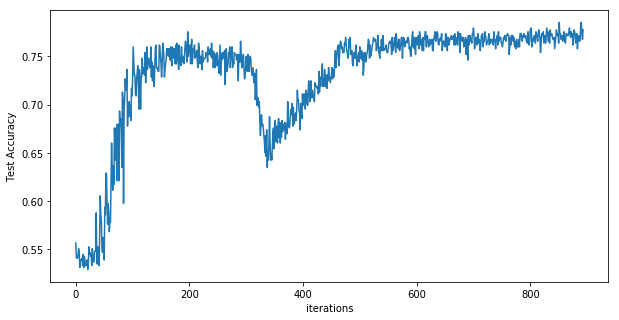

In [27]:
plt.figure(figsize=(10,5))
plt.plot(test_acc)
plt.xlabel("iterations")
plt.ylabel("Test Accuracy")
plt.savefig(OUTPUT_PATH + "test_acc.png")
plt.show()

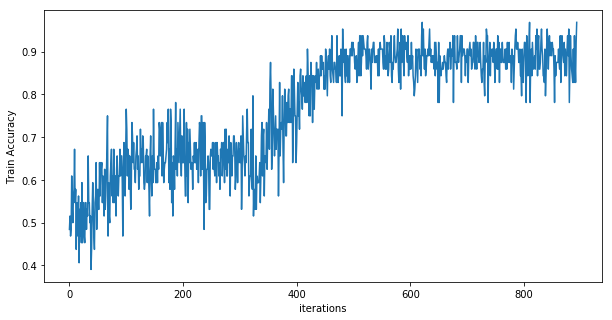

In [28]:
plt.figure(figsize=(10,5))
plt.plot(train_acc[::50])
plt.xlabel("iterations")
plt.ylabel("Train Accuracy")
plt.savefig(OUTPUT_PATH + "train_acc.png")
plt.show()

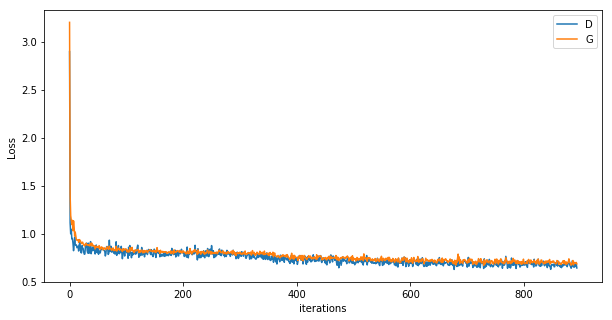

In [29]:
plt.figure(figsize=(10,5))
plt.plot(d_losses[::50], label="D")
plt.plot(g_losses[::50], label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(OUTPUT_PATH + "loss.png")
plt.show()

In [26]:
fake_img_list = []
fake_label_list = []
for gen_num in range(1000):
    z = Variable(FloatTensor(np.random.normal(0, 1, (BATCH_SIZE, 100))))
    gen_labels = Variable(LongTensor(np.random.randint(0, LEVELS_NUM, BATCH_SIZE)))
    with torch.no_grad():
        fake = generator(z,gen_labels).detach().cpu()
        fake = fake.tolist()
        fake_label_list.extend(gen_labels)
        fake_img_list.extend(fake)
np.save(OUTPUT_PATH + "fake.npy", np.array(fake_img_list))
np.save(OUTPUT_PATH + "fake_label.npy", np.array(fake_label_list))